# Solução 2:  Validação Cruzada Para Seleção de Modelos

## Objetivos:

O objetivo desse desafio é compreender como funciona a validação cruzada e os benefícios em se utilizar essa técnica para selecionar modelos mais genéricos.


## Conceitos:

A validação cruzada é uma técnica de avaliação de um modelo em treinamento que permite estimar a capacidade de **generalização** do mesmo. A idéia por trás da técnica é validar qual seria o desempenho do modelo, treinado com uma parte dados, sobre o resto dos dados, nunca vistos antes pelo modelo. 

Essa técnica possibilita que se teste essa hipótese sem ser necessário ter uma base de testes extra, o que é muito útil quando se têm poucos dados. O diagrama abaixo resume a idéia central da técnica:


![Diagrama explicativo: Cross-Validation usando K-Fold com ${K = 10}$](images/k-fold-diagram.png)

A técnica mais comum, denominada `K-Fold`, consiste em particionar o dataset em $K$ grupos, treinar com $K-1$ grupos de dados e validar o modelo treinado sobre o grupo restante. Deve-se repetir esse passo $K$ vezes, para que todos os grupos sejam usados, e então calcular as métricas de avaliação como a média das métricas calculadas em cada iteração. Uma outra maneira de se fazer isso é armazenar a predição sobre todos os dados **quando em validação** e calcular as métricas de desempenho sobre essas predições.

O limite dessa técnica é o `Leave-One-Out`, caso é o extremo em que se particiona o dataset em $N$ grupos. Esse limite, quando possível, traz a informação mais acurada sobre a capacidade de generalização do modelo. Essa técnica tem como desvantagem a quantidade enorme de treinamentos realizados: um para cada elemento da base de treino.

___

# Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import numpy as np
import os
import pandas as pd

In [3]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics.regression import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Dataset:

## Carregando os dados

In [4]:
from sklearn.datasets import load_boston
dataset = load_boston()

### Sobre o Dataset

In [5]:
print(dataset["DESCR"])

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [6]:
dataset.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR'])

### Separação das Features e Variável Dependente

In [7]:
x = pd.DataFrame(
    columns=dataset["feature_names"],
    data=dataset["data"]
)

In [8]:
y = dataset["target"]

In [9]:
x.shape

(506, 13)

In [10]:
x.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [11]:
y.shape

(506,)

In [12]:
y[:5]

array([ 24. ,  21.6,  34.7,  33.4,  36.2])

## Separação de Treino e Teste

In [13]:
# splitting 
train_index, test_index = train_test_split(
    x.index, 
    test_size=.3, 
    random_state=42
)

x_train = x.loc[train_index, :]
x_test = x.loc[test_index, :]
y_train = y[train_index]
y_test = y[test_index]

In [14]:
x_train.shape

(354, 13)

In [15]:
x_test.shape

(152, 13)

## Normalizando Features com Z-Score

Passo importante quando se treina modelos lineares, por eliminar importâncias artificialmente grandes para features contendo valores muito grandes.

In [16]:
zscore = StandardScaler().fit(x_train)
x_train = zscore.transform(x_train)
x_test = zscore.transform(x_test)

# Problemas

## A) Seleção de Hiperparâmetros

O uso mais comum da técnica é a seleção dos `hiperparâmetros` que definem o modelo; 
diferente dos parâmetros do modelo, que são ajustados a cada iteração do treinamento, os hiperparâmetros são condições fixadas sob as quais o treinamento ocorre. Um exemplo de hiperparâmetro é o $alpha$, definido para treinamentos das regressões `Ridge` e `Lasso`.

Nessa seção, será feita a busca pelos melhores hiperparâmetros de treinamento usando a $ElasticNet$, que combina a regularização `L1` e `L2` em um modelo único. 

### Escolha dos Hiperparâmetros

Os hiperparâmetros a serem variados são:
* `alpha`: mesmo parâmetro visto em Regularização, define a intensidade da regularização no modelo.
* `l1_ratio `: define o tipo de regularização, como mostrado abaixo:
    * $l1\_ratio = 1$: o treinamento ocorre com `L1` apenas
    * $l1\_ratio = 0$: o treinamento ocorre com `L2` apenas
    * $0 \leq l1\_ratio \leq 1$: o treinamento ocorre com uma combinação de `L1` com `L2` na proporção dada.

#### Variação dos hiperparâmetros

In [17]:
# hiperparâmetros
param_grid = {
    "alpha": np.logspace(-3, 4, 11),          # Por quê `logspace`?
    "l1_ratio": np.linspace(0.01, 1.0, 11),
    "max_iter": [100],
    "positive": [True]
}

##### Treinamento dos modelos

Usar o [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) para treinar um conjunto de modelos com a combinação de todos os hiperparâmetros.

Parâmetros a serem utilizados:

* `estimator`: [`ElasticNet()`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)
* `param_grid `: `param_grid`
* `scoring`: 'r2'
* `cv`: usar [`KFold(n_splits=10, shuffle=True, random_state=42)`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)
* `random_state`: 42

In [18]:
grid = GridSearchCV(
    ElasticNet(), 
    param_grid=param_grid, 
    scoring='r2',
    cv=KFold(n_splits=10, shuffle=True, random_state=42)
)

In [19]:
grid.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
       error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.00000e-03,   5.01187e-03,   2.51189e-02,   1.25893e-01,
         6.30957e-01,   3.16228e+00,   1.58489e+01,   7.94328e+01,
         3.98107e+02,   1.99526e+03,   1.00000e+04]), 'l1_ratio': array([ 0.01 ,  0.109,  0.208,  0.307,  0.406,  0.505,  0.604,  0.703,
        0.802,  0.901,  1.   ]), 'max_iter': [100], 'positive': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=0)

In [20]:
model = grid.best_estimator_

In [21]:
y_pred = model.predict(x_train)
y_true = y_train
r2_score(y_true=y_true, y_pred=y_pred), mean_squared_error(y_true=y_true, y_pred=y_pred)

(0.56734133099549833, 38.029195426221513)

In [22]:
y_pred = model.predict(x_test)
y_true = y_test
r2_score(y_true=y_true, y_pred=y_pred), mean_squared_error(y_true=y_true, y_pred=y_pred)

(0.55781858757307035, 32.948305842502236)

####  Avaliação dos modelos treinados

Mostrar uma tabela contendo todos os treinamentos e suas avaliações e escolher um range de exploração onde o modelo consegue ter uma performance melhor.

Dica: usar a função [`heatmap`](https://seaborn.pydata.org/generated/seaborn.heatmap.html) do `seaborn` para visualizar os melhores parâmetros.

In [23]:
results = pd.DataFrame(grid.cv_results_)[['param_alpha', 'param_l1_ratio', 'mean_test_score']]
results = results.set_index(['param_alpha', 'param_l1_ratio']).unstack()
results.columns = results.columns.droplevel(0)
results

param_l1_ratio,0.01,0.109,0.208,0.307,0.406,0.505,0.604,0.703,0.802,0.901,1.0
param_alpha,,,,,,,,,,,
0.001000,0.506555,0.506547,0.506539,0.506532,0.506524,0.506516,0.506508,0.506500,0.506493,0.506485,0.506477
0.005012,0.506887,0.506850,0.506813,0.506776,0.506738,0.506700,0.506662,0.506624,0.506586,0.506547,0.506508
0.025119,0.508295,0.508152,0.508004,0.507852,0.507694,0.507532,0.507365,0.507192,0.507015,0.506832,0.506644
0.125893,0.509552,0.509767,0.509919,0.509955,0.509861,0.509616,0.509271,0.508830,0.508285,0.507628,0.506848
0.630957,0.464269,0.468684,0.473141,0.477590,0.481957,0.486257,0.490533,0.493956,0.496178,0.497046,0.495808
3.162278,0.253617,0.252244,0.250564,0.248460,0.245769,0.243805,0.244453,0.247778,0.258690,0.284166,0.325370
15.848932,0.044495,0.014539,-0.010431,-0.025475,-0.043862,-0.046385,-0.046385,-0.046385,-0.046385,-0.046385,-0.046385
79.432823,-0.029350,-0.046385,-0.046385,-0.046385,-0.046385,-0.046385,-0.046385,-0.046385,-0.046385,-0.046385,-0.046385
398.107171,-0.045396,-0.046385,-0.046385,-0.046385,-0.046385,-0.046385,-0.046385,-0.046385,-0.046385,-0.046385,-0.046385


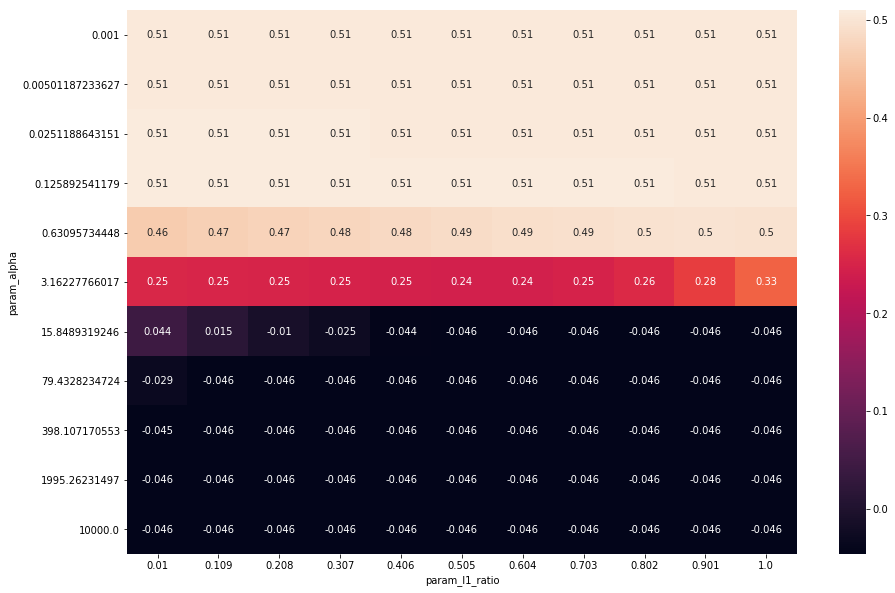

In [24]:
plt.figure(figsize=(15, 10))
sns.heatmap(results, annot=True)

## B) Estudo da influência do parâmetro $K$ sobre a generalização

Quanto mais `folds` forem usados na validação cruzada, mais realista será a estimativa do poder de generalização do modelo treinado. Como já foi citado, o uso de `LeaveOneOut` é o mais próximo de trazer essa estimativa, com o contraponto de ser o mais pesado computacionalmente.

Nessa seção, será feita uma comparação entre o desempenho dos modelos nas massas de validação (calculado com dados de treino durante a validação cruzada) e de teste. 

###### Importante:

Os hipeparâmetros a serem variados nos treinamentos devem ser obtidos na última etapa do item **A**.

####  Hiperparâmetros

Preencher `params_grid` com as faixas de hiperparâmetros de melhor performance.

In [25]:
""" Complete os espaços com ? """
param_grid = {
    "alpha": np.logspace(-2, 0, 5),
    "l1_ratio": np.linspace(0.5, 1.0, 5),
    "max_iter": [10000],
    "positive": [True]
}

####  Treinar os modelos para os valores de $K$

Treinar os modelos para cada valor de $K$ em `k_list`. Armazenar, para cada $K$, os valores de $R^2$ e de $MSE$ calculados sobre a **massa de testes**.

In [26]:
k_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

In [27]:
""" Escreva a solução aqui """

measures = pd.DataFrame(
    columns=["test MSE", "test R^2", "validation MSE", "validation R^2", "train MSE", "train R^2"],
    index=k_list,
    data=None
)

for k in k_list:
    # training grid search with cross-validation
    grid = GridSearchCV(
        ElasticNet(), 
        param_grid=param_grid, 
        scoring=['neg_mean_squared_error', 'r2'],
        cv=KFold(n_splits=k, shuffle=True, random_state=42),
        refit=False
    )
    grid.fit(x_train, y_train)
    
    # retrieving best model validation results
    cv_results = pd.DataFrame(grid.cv_results_)
    best_index = cv_results.mean_test_neg_mean_squared_error.argmin()    
    mse_tr = -cv_results.loc[best_index, 'mean_train_neg_mean_squared_error']
    r2_tr = cv_results.loc[best_index, 'mean_train_r2']
    mse_vd = -cv_results.loc[best_index, 'mean_test_neg_mean_squared_error']
    r2_vd = cv_results.loc[best_index, 'mean_test_r2']
    
    # training model w/ best params
    best_params = cv_results.loc[best_index, "params"]
    model = ElasticNet(**best_params).fit(x_train, y_train)
    
    # retrieving best model's tet results
    y_pred = model.predict(x_test)
    y_true = y_test
    mse_te = mean_squared_error(y_true, y_pred)
    r2_te = r2_score(y_true, y_pred)
    
    # filling measures table
    measures.loc[k, "test MSE"] = mse_te
    measures.loc[k, "test R^2"] = r2_te
    measures.loc[k, "train MSE"] = mse_tr
    measures.loc[k, "train R^2"] = r2_tr
    measures.loc[k, "validation MSE"] = mse_vd
    measures.loc[k, "validation R^2"] = r2_vd

measures

,test MSE,test R^2,validation MSE,validation R^2,train MSE,train R^2
5,37.8742,0.491711,46.7502,0.455226,43.9523,0.497476
10,37.8742,0.491711,46.0599,0.453003,44.134,0.497243
15,37.8742,0.491711,46.0543,0.44183,44.18,0.496896
20,37.8742,0.491711,45.9582,0.443753,44.194,0.496945
25,37.8742,0.491711,45.9818,0.375111,44.2024,0.49692
30,37.8742,0.491711,45.851,0.410228,44.2133,0.496813
35,37.8742,0.491711,45.6706,0.401214,44.2187,0.496826
40,37.8742,0.491711,45.7657,0.333201,44.2207,0.496797
45,37.8742,0.491711,45.8183,0.349195,44.222,0.496794
50,37.8742,0.491711,45.7617,0.283832,44.2248,0.49678


####  Avaliação da generalização

Mostrar em dois plots (um para $R^2$ e outro para $MSE$) a comparação entre as métricas de validação (do cross-validation) e as medidas sobre a massa de teste. 

* Eixo X: valores de  $K$
* Eixo Y: métricas de avaliação ($R^2$ / $MSE$)


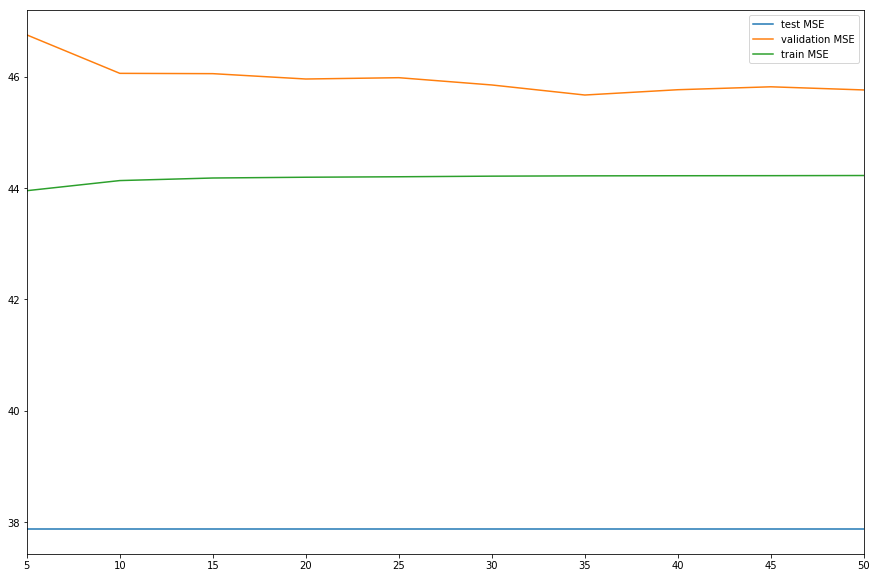

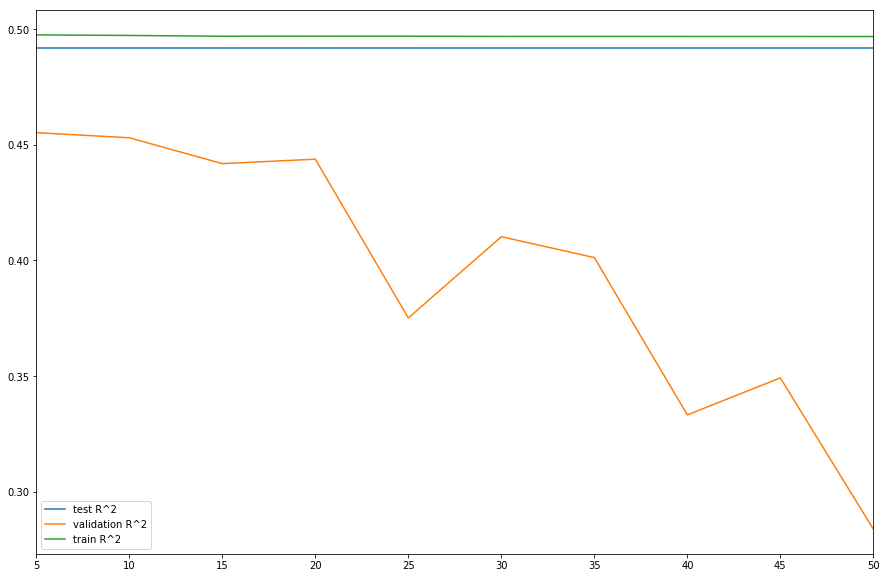

In [28]:
""" Escreva a solução aqui """
measures[["test MSE", "validation MSE", "train MSE"]].plot(figsize=(15,10))
measures[["test R^2", "validation R^2", "train R^2"]].plot(figsize=(15,10))

###### Nota sobre o exercício:

Devido à quantidade reduzida de dados, a variação dos resultados de treino/teste não estão mostrando muita diferença. O que se pretendia mostrar aqui é o quanto os resultados de modelos treinados com $K$ alto possuiem uma generalização melhor (curvas de treino e teste mais próximas).